In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm
%matplotlib inline

In [3]:
name = "GBPJPY"
priceset = pd.read_csv("priceset.csv", index_col = 0)
weekends = pd.to_datetime(priceset.index).weekday
priceset = priceset[~weekends.isin([5,6])]
columnNames = list(filter(lambda x: name in x, priceset.columns))
priceset = priceset[columnNames].fillna(method="ffill").dropna()
priceset.columns = list(map(lambda x: x.replace(name+"_", ""), priceset.columns))

In [4]:
def extract_roll_agg(ds, per, aggName):
    # new_column = col_prefix + ds.name + '_' + str(per)
    new_series = ds.rolling(min_periods=per, window=per).agg(aggName)
    # new_series.name = new_column
    return new_series

def extract_macd(ds, per_1=12, per_2 = 26, per_signal = 9):
    exp1 = ds.ewm(span=per_1, adjust=False).mean()
    exp2 = ds.ewm(span=per_2, adjust=False).mean()
    macd = exp1-exp2
    signal_macd = macd.ewm(span=per_signal, adjust=False).mean()
    return macd, signal_macd

In [35]:
Xy = priceset.copy()
periods =  [24] #1,3,6,12,24 hours 4,12,24,48,96

Xy["high_1h"] = extract_roll_agg(Xy["high"], 4, "max")
Xy["low_1h"] = extract_roll_agg(Xy["high"], 4, "min")

# Xy["candle_body"] = Xy["high"] - Xy["low"]

# Xy["high_close_diff"] = Xy["high"] - Xy["close"].shift(1)
# Xy["low_close_diff"] = Xy["low"] - Xy["close"].shift(1)

# Xy["high_1h_close_diff"] = Xy["high_1h"] - Xy["close"]
# Xy["low_1h_close_diff"] = Xy["low_1h"] - Xy["close"]

# Xy["macd_base_high"], Xy["macd_signal_high"] = extract_macd(Xy["high"])
# Xy["macd_base_low"], Xy["macd_signal_low"] = extract_macd(Xy["low"])

# Xy["csum_high_close_diff_24"] = extract_roll_agg(Xy["high_close_diff"], 24, "sum")
# Xy["csum_low_close_diff_24"] = extract_roll_agg(Xy["low_close_diff"], 24, "sum")

# Xy["RS"] = Xy["high_close_diff"] / (Xy["low_close_diff"] + 0.000001)

features = Xy.columns

for each_col in tqdm.tqdm_notebook(features):
  newcolName = each_col
  for each_shift in range(1,2):
    shift_per = str(each_shift)
    Xy["prev_"+shift_per+"_"+newcolName] = Xy[each_col].shift(each_shift)

Xy["csum_ar_1_high_24"] = extract_roll_agg(Xy["high"]-Xy["prev_1_high"], 24, "sum")
Xy["csum_ar_1_low_24"] = extract_roll_agg(Xy["low"]-Xy["prev_1_low"], 24, "sum")

features = Xy.columns

for each_col in tqdm.tqdm_notebook(features):
  for each_col2 in features:
    if each_col != each_col2:
      newcolName = "diff_"+each_col + "_" + each_col2
      Xy[newcolName] = Xy[each_col] - Xy[each_col2]

Xy["csum_high_close_diff_24"] = extract_roll_agg(Xy["diff_high_close"], 24, "sum")
Xy["csum_low_close_diff_24"] = extract_roll_agg(Xy["diff_low_close"], 24, "sum")

# Xy["csum_ar_1_high_24"] = extract_roll_agg(Xy["diff_high"]-Xy["prev_1_high"], 24, "sum")
# Xy["csum_ar_1_low_24"] = extract_roll_agg(Xy["diff_low"]-Xy["prev_1_low"], 24, "sum")

# for each_col in tqdm.tqdm_notebook(features):
#   newcolName = each_col

#   for each_ar in range(1,2):
#     ar_per = str(each_ar)
#     Xy["ar_"+ar_per+"_"+newcolName] = Xy[each_col] - Xy[each_col].shift(each_ar)

# Xy["csum_ar_1_high_24"] = extract_roll_agg(Xy["ar_1_high"], 24, "sum")
# Xy["csum_ar_1_low_24"] = extract_roll_agg(Xy["ar_1_low"], 24, "sum")

Xy["target"] = 0
Xy.loc[(Xy["high"] < Xy["high"].shift(-1)) & (Xy["low"] <= Xy["low"].shift(-1)), "target"] = 1
Xy.loc[(Xy["high"] >= Xy["high"].shift(-1)) & (Xy["low"] > Xy["low"].shift(-1)), "target"] = 2
Xy = Xy.dropna().copy()
X = Xy.drop(columns=['high', 'low', 'close', 'open', 'tick_volume', 'target', 'high_1h', 'low_1h'])
y = Xy["target"].copy()


In [36]:
X = X.drop(columns=['prev_1_low_1h', 
                    'diff_high_tick_volume', 
                    'diff_high_prev_1_close',
       'diff_high_prev_1_tick_volume',
                    
                    'diff_high_csum_ar_1_high_24',
       'diff_high_csum_ar_1_low_24', 'diff_low_prev_1_tick_volume',
       'diff_low_csum_ar_1_high_24', 'diff_close_tick_volume',
       'diff_close_prev_1_low_1h', 'diff_close_csum_ar_1_high_24',
       'diff_close_csum_ar_1_low_24', 'diff_open_tick_volume',
       'diff_open_csum_ar_1_high_24', 'diff_open_csum_ar_1_low_24',
       'diff_tick_volume_high', 'diff_tick_volume_low',
       'diff_tick_volume_close', 'diff_tick_volume_high_1h',
       'diff_tick_volume_prev_1_high', 'diff_tick_volume_prev_1_open',
       'diff_low_1h_high', 'diff_low_1h_prev_1_tick_volume',
       'diff_prev_1_high_tick_volume', 'diff_prev_1_high_high_1h',
       'diff_prev_1_high_prev_1_tick_volume',
       'diff_prev_1_high_csum_ar_1_high_24',
       'diff_prev_1_low_prev_1_tick_volume', 'diff_prev_1_close_tick_volume',
       'diff_prev_1_close_high_1h', 'diff_prev_1_close_prev_1_open',
       'diff_prev_1_close_prev_1_tick_volume',
       'diff_prev_1_close_csum_ar_1_low_24', 'diff_prev_1_open_low',
       'diff_prev_1_open_tick_volume', 'diff_prev_1_open_csum_ar_1_high_24',
       'diff_prev_1_open_csum_ar_1_low_24', 'diff_prev_1_tick_volume_high',
       'diff_prev_1_tick_volume_open', 'diff_prev_1_tick_volume_high_1h',
       'diff_prev_1_tick_volume_low_1h', 'diff_prev_1_tick_volume_prev_1_low',
       'diff_prev_1_tick_volume_prev_1_open',
       'diff_prev_1_tick_volume_prev_1_high_1h',
       'diff_prev_1_tick_volume_prev_1_low_1h',
       'diff_prev_1_high_1h_tick_volume',
       'diff_prev_1_high_1h_prev_1_tick_volume',
       'diff_prev_1_high_1h_csum_ar_1_high_24',
       'diff_prev_1_high_1h_csum_ar_1_low_24', 'diff_prev_1_low_1h_open',
       'diff_prev_1_low_1h_tick_volume', 'diff_prev_1_low_1h_prev_1_open',
       'diff_prev_1_low_1h_prev_1_high_1h',
       'diff_prev_1_low_1h_csum_ar_1_high_24',
       'diff_prev_1_low_1h_csum_ar_1_low_24', 'diff_csum_ar_1_high_24_high',
       'diff_csum_ar_1_high_24_low', 'diff_csum_ar_1_high_24_low_1h',
       'diff_csum_ar_1_high_24_prev_1_high',
       'diff_csum_ar_1_high_24_prev_1_low', 'diff_csum_ar_1_low_24_high',
       'diff_csum_ar_1_low_24_prev_1_open',
       'diff_csum_ar_1_low_24_prev_1_high_1h',
       'diff_csum_ar_1_low_24_prev_1_low_1h',
        'diff_low_csum_ar_1_low_24', 'diff_close_prev_1_tick_volume',
       'diff_open_prev_1_tick_volume', 'diff_tick_volume_prev_1_low_1h',
       'diff_high_1h_tick_volume', 'diff_high_1h_prev_1_tick_volume',
       'diff_high_1h_csum_ar_1_high_24', 'diff_prev_1_low_csum_ar_1_high_24',
       'diff_prev_1_low_csum_ar_1_low_24',
       'diff_prev_1_close_csum_ar_1_high_24',
       'diff_prev_1_tick_volume_prev_1_high', 'diff_csum_ar_1_low_24_low',
       'diff_csum_ar_1_low_24_open', 'diff_csum_ar_1_low_24_low_1h',
                   'diff_open_prev_1_low_1h', 'diff_tick_volume_prev_1_low',
       'diff_low_1h_csum_ar_1_high_24', 'diff_prev_1_close_prev_1_high_1h',
       'diff_prev_1_high_1h_close', 'diff_csum_ar_1_high_24_high_1h',
                   'diff_prev_1_high_1h_prev_1_open', 'diff_csum_ar_1_low_24_close'])

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

from sklearn.ensemble import GradientBoostingClassifier
gr_clf = GradientBoostingClassifier(n_estimators=50, verbose=1)
gr_clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0617            1.82m
         2           1.0386            1.81m
         3           1.0194            1.78m
         4           1.0032            1.73m
         5           0.9897            1.70m
         6           0.9782            1.66m
         7           0.9682            1.62m
         8           0.9595            1.59m
         9           0.9523            1.55m
        10           0.9459            1.51m
        20           0.9107            1.11m
        30           0.8976           44.43s
        40           0.8900           22.04s
        50           0.8847            0.00s


GradientBoostingClassifier(n_estimators=50, verbose=1)

accuracy is  0.5843383584589614
[[ 479 1238 1323]
 [ 339 3325  857]
 [ 338  868 3173]]


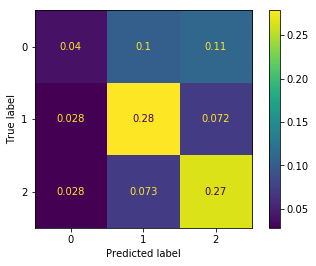

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = gr_clf.predict(X_test)
print("accuracy is ", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(gr_clf, X_test, y_test, normalize="all")

In [ ]:
accuracy is  0.5843383584589614
[[ 479 1238 1323]
 [ 339 3325  857]
 [ 338  868 3173]]

In [38]:
importance = pd.DataFrame(zip(gr_clf.feature_importances_, X.columns), columns = ["importance", "feature"]).set_index("feature")
importance.sort_values("importance", ascending=False)

,importance
feature,
diff_high_close,0.235188
diff_low_close,0.198802
diff_close_high,0.173003
diff_close_low,0.112647
diff_close_open,0.111738
...,...
diff_prev_1_tick_volume_low,0.000039
diff_prev_1_low_1h_prev_1_tick_volume,0.000034
diff_open_high,0.000027


In [49]:
for i in importance.sort_values("importance", ascending=False).reset_index().values:
    print(i[0], i[1])

diff_high_close 0.23518762581567024
diff_low_close 0.19880162220744332
diff_close_high 0.17300340114323323
diff_close_low 0.11264674135769435
diff_close_open 0.1117376696978006
diff_high_1h_low_1h 0.02177179060015986
diff_close_prev_1_close 0.0158064326448595
diff_low_1h_high_1h 0.014551369850263346
diff_prev_1_close_close 0.014370673794542621
diff_low_high 0.01125523786243482
diff_high_low 0.004413210797738307
diff_open_close 0.004344855666122561
diff_csum_ar_1_low_24_csum_ar_1_high_24 0.002890588605996894
diff_csum_ar_1_high_24_csum_ar_1_low_24 0.0027241631085709694
diff_csum_ar_1_high_24_prev_1_tick_volume 0.002454745068861623
diff_low_high_1h 0.002433893230288317
diff_prev_1_tick_volume_tick_volume 0.0024079657403218886
diff_tick_volume_prev_1_tick_volume 0.002342916924505931
diff_low_prev_1_low 0.002337476514195791
csum_low_close_diff_24 0.0019322734294555314
diff_prev_1_close_open 0.00164521596778206
diff_prev_1_high_1h_open 0.001522141365621261
diff_prev_1_high_high 0.0014280228

In [ ]:
diff_high_close 
diff_low_close 
diff_close_open 
diff_high_1h_low_1h 
diff_close_prev_1_close 
diff_low_high 

In [40]:
importance[importance["importance"]==0].index

Index(['diff_prev_1_high_1h_prev_1_open', 'diff_csum_ar_1_low_24_close'], dtype='object', name='feature')